In [1]:
import pandas as pd
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor, Lars, BayesianRidge
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

from scipy import stats
from scipy.stats import norm, skew, boxcox
from scipy.special import boxcox1p, inv_boxcox
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [2]:
fnc = pd.read_csv('fnc.csv')
loading = pd.read_csv('loading.csv')
reveal = pd.read_csv('reveal_ID_site2.csv')
sample = pd.read_csv('sample_submission.csv')
train_scores = pd.read_csv('train_scores.csv')

fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])
loading = loading.drop(['IC_20'], axis=1)
loading_features.remove('IC_20')

In [3]:
df = fnc.merge(loading, on="Id")

In [4]:
np.random.seed(0)
SEED = 0
NUM_FOLDS = 7
FNC_SCALE = 1/500

In [5]:
scaler = MinMaxScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
scaler = RobustScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])

train_scores["is_train"] = True
df = df.merge(train_scores, on="Id", how="left")

test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

In [6]:
df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE

In [7]:
for col in ['domain1_var1','domain1_var2','domain2_var1','domain2_var2']:
    print('{} min'.format(col), df[df[col].notnull()][col].min() )
    print('{} 01th percentile'.format(col), np.quantile( df[df[col].notnull()][col], 0.01))
    print('{} 99th percentile'.format(col), np.quantile( df[df[col].notnull()][col], 0.99))
    print('{} max'.format(col), df[df[col].notnull()][col].max() )

domain1_var1 min 15.769168440909901
domain1_var1 01th percentile 26.58061988855929
domain1_var1 99th percentile 73.02125412101981
domain1_var1 max 81.32558046682091
domain1_var2 min 1.02187412680241
domain1_var2 01th percentile 28.27045302027076
domain1_var2 99th percentile 81.57128873138902
domain1_var2 max 94.7028742938426
domain2_var1 min 0.991171589270998
domain2_var1 01th percentile 19.2253225107988
domain2_var1 99th percentile 70.77440609445974
domain2_var1 max 82.16447810733759
domain2_var2 min 0.81528459031756
domain2_var2 01th percentile 21.147699249805104
domain2_var2 99th percentile 77.53994705843043
domain2_var2 max 94.5099033141969


In [8]:
for col in ['domain1_var1','domain1_var2','domain2_var1','domain2_var2']:
    lower_quant = np.quantile( df[df[col].notnull()][col], 0.01)
    upper_quant = np.quantile( df[df[col].notnull()][col], 0.99)
    df.loc[(df[col] <= lower_quant), col]  = np.nan
    df.loc[(df[col] >= upper_quant), col]  = np.nan

In [17]:
target = 'domain1_var1'
features = loading_features + fnc_features 
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, df[df[target].notnull()][features], df[df[target].notnull()][target], scoring='neg_mean_squared_error', cv=NUM_FOLDS))
    return rmse

In [18]:
%%time

alphas_ridge = [ 0.054, 0.055, 0.056, 0.057 ]
cv_ridge = [rmse_cv(Ridge(alpha = al)).mean() for al in alphas_ridge]

cv_ridge = pd.Series(cv_ridge, index=alphas_ridge)
print(cv_ridge)

0.054    9.205568
0.055    9.205379
0.056    9.205202
0.057    9.205036
dtype: float64
CPU times: user 30 s, sys: 8.16 s, total: 38.1 s
Wall time: 10.3 s


Text(0, 0.5, 'rmse')

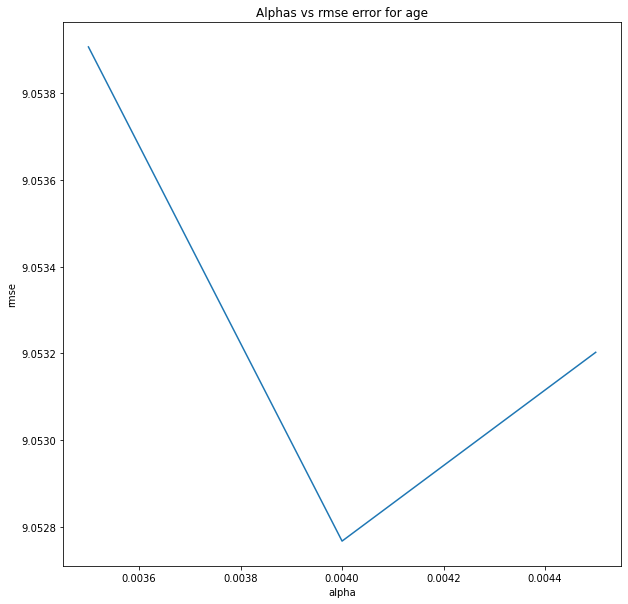

In [9]:
plt.figure(figsize=(10,10))
cv_ridge.plot(title='Alphas vs rmse error for {}'.format(target))
plt.xlabel('alpha')
plt.ylabel('rmse')

In [9]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
features = loading_features + fnc_features
overal_score = 0
for target, c, w, al in [ ('age', 6, 0.3, 0.004), ('domain1_var1', 0, 0.175, 0.08),('domain1_var2', 0, 0.175, 0.22),('domain2_var1', 0, 0.175, 0.05),('domain2_var2', 0, 0.175, 0.047)]:    

    y_oof = np.zeros(df.shape[0])
    y_test = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = Ridge(alpha = al)
        model.fit(train_df[features], train_df[target])

        y_oof[val_ind] = model.predict(val_df[features])
        y_test[:, f] = model.predict(test_df[features])
        
    df["pred_{}".format(target)] = y_oof
    test_df[target] = y_test.mean(axis=1)
    
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)
    overal_score += w*score
    print(target, np.round(score, 5), np.round(score, 4))
    
print("\nOverall score:", np.round(overal_score, 5), np.round(overal_score, 4))

age 0.14293 0.1429
domain1_var1 0.14457 0.1446
domain1_var2 0.14329 0.1433
domain2_var1 0.17141 0.1714
domain2_var2 0.16632 0.1663

Overall score: 0.15236 0.1524


In [ ]:
#submission

In [10]:
sub_df = pd.melt(test_df[["Id", "age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.head(10)

Id  Predicted
0               10003_age  59.621590
5877   10003_domain1_var1  48.598144
11754  10003_domain1_var2  60.432825
17631  10003_domain2_var1  49.723556
23508  10003_domain2_var2  55.797171
1               10006_age  63.221566
5878   10006_domain1_var1  54.406087
11755  10006_domain1_var2  58.646868
17632  10006_domain2_var1  48.889666
23509  10006_domain2_var2  51.987682

In [11]:
sub_df.to_csv('subs/checking_effect_of_outlier_removal_target_based.csv', index=False)

In [1]:
#koi farak nahi pada 0.1599 hi raha
#maybe test set me outlier targets bhi hain